<a href="https://colab.research.google.com/github/JunStatistic/ML_2022/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Perceptron Learning Algorithm (PLA)

PLA is a **poorly performing algorithm**, but it illustrates the idea of machine learning.

* input: $\mathcal{X} \in \mathbb{R}^d$ 
* data: $N$ sets of previous inputs and outcomes ($\mathbf{x}_i$, $y_i$) $\text{for i in 1..N}$
* output: $\mathcal{Y}$: approve credit
* target function: $f$: $\mathcal{X} → \mathcal{Y}$   No way to know this
* hypthothesis function $g$: $\mathcal{X} → \mathcal{Y}$  we learn this

We do not know what the true target function $f$ might be. So we use machine learning to find a hypothesis function $g$, which will be *approximately* equal to $f$, or $f\approx g$.

Here is some example data. We use only two factors so we can plot it in two dimensional plots.

In [1]:
import numpy as np
np.random.seed(0) # for reproducibility

data = np.array(((3.0, 4.0), (4.0, 6.0), (4.3, 4.0), (8.0, 7.0), 
                 (6.0, 5.5), (6.4, 8.2), (1.0, 7.0), (4.0, 5.2),  
                 (7.0, 7.5), (5.0, 2.0), (7.0, 6.0), (7.0, 3.0),
                 (6.0, 8.4), (2.0, 3.6), (1.0, 2.7)))

## Definition of Perceptron
A **peceptron** models the hypothesis function as a sum of weights. 

If we let $d$ be the dimension of input data, then the perceptron is

$$\text{approve credit if } \sum\limits_{i=1}^d w_i x_i >\text{ threshold}$$

or
$$h(\mathbf{x}) = \text{sign}\Big[\sum\limits_{i=1}^d w_i x_i - \text{threshold}\Big]$$

In other words, $h(\mathbf{x})$ will be $1$ if we approve credit, and $-1$ if we deny credit.

To test our code we need to simulate the function $f$, which is normally unknow. Here we arbitrarily define it as approving the credit if the sum of the $\mathbf{x}$ and $y$ factors is less than 10.5. In other words, if $x_1 + x_2 < 10.5$ that person didn't make us money, otherwise they did make us money.

In [2]:
def true_fuction_f(data):
    return np.sign(data[:, 1] + data[:, 0] - 10.5)

Let's look at that in a plot. I'll write a function to plot the data points in blues plus marks for approve, and red minuses for deny.

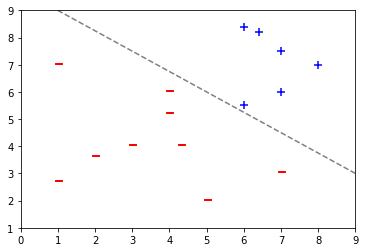

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_costs(ax, x1, x2, y):
    for i, c in enumerate(y):  
        plt.scatter(x1[i], x2[i], marker='+' if c==1 else '$-$',
                    c='b' if c==1 else 'r', s=50)

y = true_fuction_f(data)

fig, ax = plt.subplots(1)
plot_costs(ax, data[:, 0], data[:, 1], y)
plt.plot([9, 1], [3, 9], ls='--', color='grey');
plt.xlim(0, 9); plt.ylim(1, 9);

## Perceptron in a vector form
We want to implement the Perceptron in a vector form using linear algebra. We can get rid of the $> \text{threshold}$ term by introducing a dummy term $x_0$, which we always set to 1. We introduce a new weight $w_0$ corresponding to it. This lets us write our hypothesis function as

$$h(\mathbf{x}) = \text{sign}\Big[\sum\limits_{i=0}^d w_i x_i \Big]$$

$\sum\limits_{i=0}^d w_i x_i$ is called an **inner product** in linear algebra, and we can calculate it extremely quickly with `numpy.inner()` and `numpy.sign()`. It is written as

$$h(\mathbf{x}) = \text{sign}(\mathbf{w}^\mathsf{T}\mathbf{x})$$

Here is an example for $4*1 + 3*4 + 2*7$ (weights are 4, 3 and 2, x's are 1, 4 and 7):

In [4]:
x = np.array([1, 4, 7])
w = np.array([4, 3, 2])
np.inner(w, x)

30

Alternatively we could use `numpy.dot` to compute the same value, but inner better conveys what we are doing:

In [5]:
np.dot(w, x)

30

To cover multiple input, we can define Perceptron as below:

**Please note that in impletation we usually define data in matrix form of $[N, d]$.**

In [8]:
def perceptron(weights, x):

  return np.sign(np.inner(weights.T, x))

Test on multiple inputs.

In [9]:
N = 20
d = 2
x = np.random.randn(N, d)
w = np.random.rand(d, 1)
print(perceptron(w, x))

[[ 1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
  -1.  1.]]


We need to add $x_0 = 1$ to our data, our data is stored in column format (each row is a separate record), so we need to add a column of ones to the left of the matrix `data` using `numpy.ones()` and `numpy.c_()` method.


In [10]:
def add_one_column(data):
    # number of data records
    N = len(data) 

    # add column of ones for x_0
    return np.c_[np.ones(N), data] 

X = add_one_column(data)
X

array([[1. , 3. , 4. ],
       [1. , 4. , 6. ],
       [1. , 4.3, 4. ],
       [1. , 8. , 7. ],
       [1. , 6. , 5.5],
       [1. , 6.4, 8.2],
       [1. , 1. , 7. ],
       [1. , 4. , 5.2],
       [1. , 7. , 7.5],
       [1. , 5. , 2. ],
       [1. , 7. , 6. ],
       [1. , 7. , 3. ],
       [1. , 6. , 8.4],
       [1. , 2. , 3.6],
       [1. , 1. , 2.7]])

## How does PLA works
We start by assigning random numbers to the weight vector. Perform the inner product against our data set. Compare to actual results.

Take *one* of the misclassified points and *nudge* the weight so that the point is no longer misclassified. This nudge fixes this point, but of course might cause one or more other points to become misclassified. But against that point we might also fix the categorization of some points as well.

$\mathbf{w}^\mathsf{T}\mathbf{x}$ is a linear operator - it creates a line. When we start with random weights this is the same as creating a random line drawn through our space. It is unlikely to correctly partition our data points correctly. When we *nudge* the weight we are shifting the line so the point is on the other side of the line. So you can visualize the algorithm as moving the line around until it correctly separates our points. 

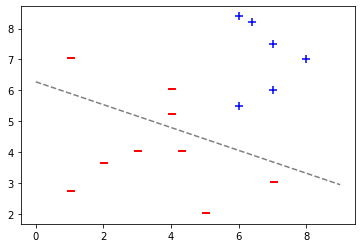

In [11]:
weights = [-8.4805, .5, 1.351]

def plot_weight_line(ax, weights, x1, x2, color='g'):
    def eq(w, x):
        """ convert w0 + w1*x1 + w2*x2 into y = mx + b"""
        return (-w[1]*x - w[0]) / w[2] 
    ax.plot([x1, x2], [eq(weights, x1), eq(weights, x2)], ls='--', color=color)
     
def plot_weight_example(ax, weights, color='g'):
    plot_weight_line(ax, weights, 0, 9, color=color)
    plot_costs(ax, data[:, 0], data[:, 1], y)
    
fig, ax = plt.subplots(1)
plot_weight_example(ax, weights, color='grey')

And after some weight change to move the line so that the point at (4, 5.2) is on the correct side of the line:

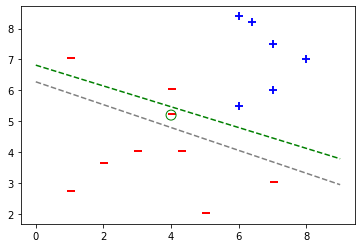

In [12]:
learningRate = 0.02 # optional: will be cover
new_weights = weights + -1 * np.array([1, 4, 5.2]) * learningRate

fig, ax = plt.subplots(1)
plot_weight_example(ax, weights, color='grey')
plot_weight_example(ax, new_weights, color='g')
ax.scatter(4, 5.2, facecolors='none', edgecolors='g', s=100, color='green')
plt.show()

Lets think about the geometric interpretation of the inner product $\mathbf{w}^\mathsf{T}\mathbf{x}$.

If the inner product is positive (accept the application) then the angle formed by $\mathbf{w}$ and $\mathbf{x}$ will be acute.

If the inner product is negative (deny the application) then the angle will be oblique.

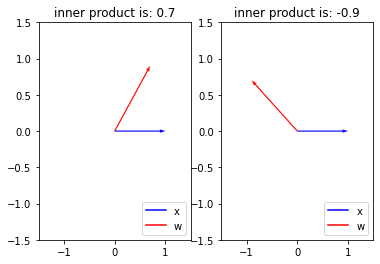

In [ ]:
def plot_vector(ax, x, c='b', label=''):
    ax.quiver(0,0,x[0], x[1],angles='xy',scale_units='xy',scale=1, color=c)
    ax.plot([0], [0], color=c, label=label)

x = [1.0, 0.0]

fig, ax = plt.subplots(1, 2)

w = [.7, 0.9]
plot_vector(ax[0], x, 'b', 'x')
plot_vector(ax[0], w, 'r', 'w')
ax[0].set_xlim(-1.5, 1.5); ax[0].set_ylim(-1.5,1.5);
ax[0].set_title('inner product is: {}'.format(np.dot(x, w)))
ax[0].legend(loc=4)

w = [-.9, .7]
plot_vector(ax[1], x, 'b', 'x')
plot_vector(ax[1], w, 'r', 'w')
ax[1].set_xlim(-1.5, 1.5); ax[1].set_ylim(-1.5,1.5);
ax[1].set_title('inner product is: {}'.format(np.dot(x, w)))
ax[1].legend(loc=4)

fig.show()

If the angle is acute ($h(x)$ is positive) and the point is misclassified this means the inner product is positive, but it should be negative: $y=-1$. If we add $yx$ to the weight, i.e. $-x$ the angle will be converted to an oblique angle. Likewise, if the angle is oblique ($h(x)$ is negative) and the point is misclassified then $y=+1$. If we add $yx$ to the weight, i.e $+x$ the angle will be converted to an acute angle: 

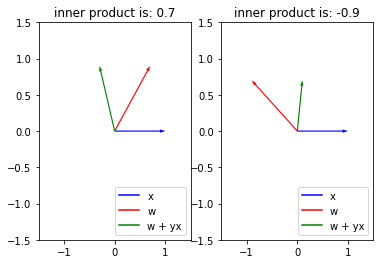

In [ ]:
x = [1.0, 0.0]
w = [.7, 0.9]
_y = -1 

fig, ax = plt.subplots(1, 2)

plot_vector(ax[0], x, 'b', 'x')
plot_vector(ax[0], w, 'r', 'w')
plot_vector(ax[0], w + np.dot(_y, x), 'g', 'w + yx')
ax[0].set_xlim(-1.5, 1.5); ax[0].set_ylim(-1.5,1.5);
ax[0].set_title('inner product is: {}'.format(np.dot(x, w)))
ax[0].legend(loc=4)

w = [-.9, .7]
_y = +1
plot_vector(ax[1], x, 'b', 'x')
plot_vector(ax[1], w, 'r', 'w')
plot_vector(ax[1], w + np.dot(_y, x), 'g', 'w + yx')
ax[1].set_xlim(-1.5, 1.5); ax[1].set_ylim(-1.5,1.5);
ax[1].set_title('inner product is: {}'.format(np.dot(x, w)))
ax[1].legend(loc=4)

fig.show()

Therefore our **nudging** algorithm is very simple to implement. Choose a point such that $\text{sign}(\mathbf{w}^\mathsf{T}\mathbf{x}_n) \neq y_n$, which means it is misclassified. Update the weight with $\mathbf{w} \gets \mathbf{w} +y_n\mathbf{x}_n$. 

The PLA runs in a loop:

```python
while some point is misclassified:
    randomly choose a miscategorized point i
    w = w + y_i * x_i
```

PLA will not converge if the data is not linearly separable so we need to add checks for the number of iterations, and we also need to return a `success` flag indicating whether we found an answer or not. We use `numpy.random.permutation()` to randomly iterate over the points. If you don't do this you can easily enter into an infinite loop since you can endless fix point 1, which misclassifies point 2. You fix point 2, which misclassifies point 1, ad infinitum. 

In [17]:
def PLA(X, y, weights=None, max_iters=50000, learningRate=1,
        verbose=False, skip=1, ):    
  if weights is None:
      weights = np.array(np.random.random(X.shape[1]))

  misclassified = True
  success = False
  iters = 0
  indexes = range(len(X))

  while misclassified and iters < max_iters:
    if verbose and iters % skip==0:
      fig, ax = plt.subplots(1)
      plot_costs(ax, X[:, 1], X[:, 2], y)
      margin = 1
      plt.xlim([np.min(X[:, 1]-margin), np.max(X[:, 1])+margin])
      plt.ylim([np.min(X[:, 2]-margin), np.max(X[:, 2])+margin])
      plot_weight_line(ax, weights, 0, 9)
      plt.title('iteration %d'%iters)
      plt.show()    

    misclassified = False
    
    for i in np.random.permutation(indexes):
      if perceptron(weights, X[i]) != y[i]:
        weights = weights + y[i] * X[i] * learningRate
        misclassified = True

    success = not misclassified
    iters += 1
    
  return weights, success, iters

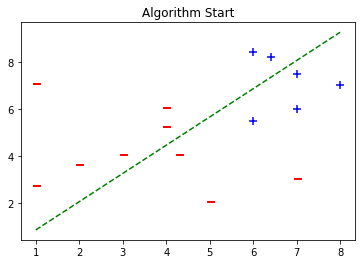

In [18]:
from numpy.random import randn

initialWeights = np.array([-0.32551368, 1.20473617, -1.00629554])

# plot initial setup
fig, ax = plt.subplots(1)

plot_weight_line(ax, initialWeights, np.min(X[:, 1]), np.max(X[:, 1]))
plot_costs(ax, X[:, 1], X[:, 2], y)
plt.title('Algorithm Start')
plt.show()

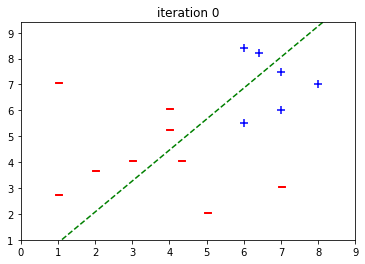

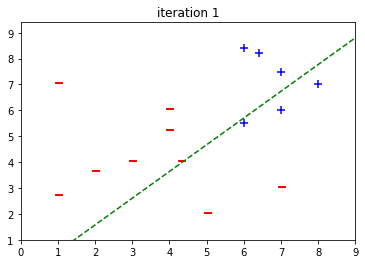

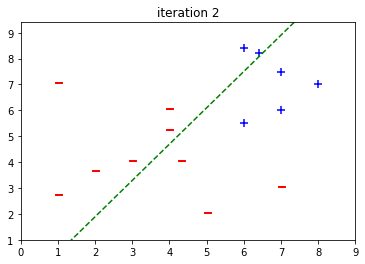

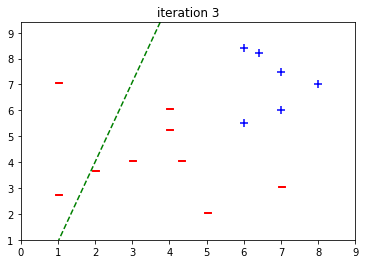

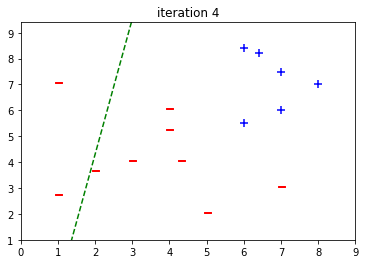

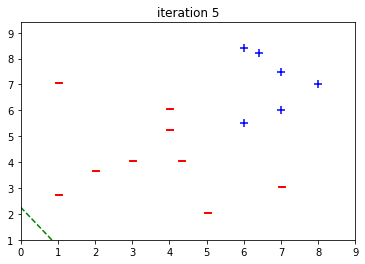

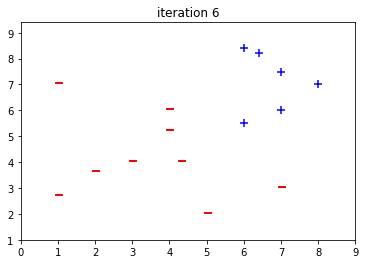

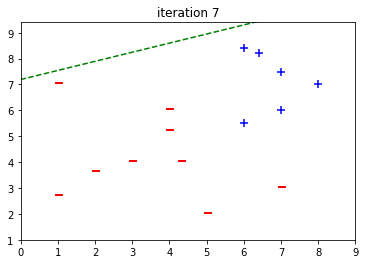

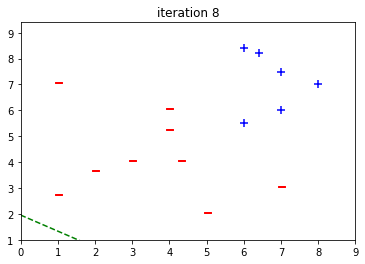

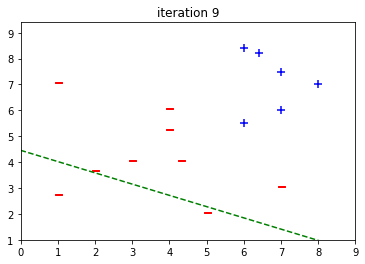

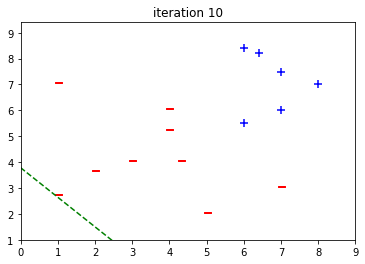

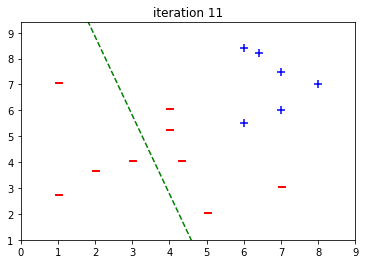

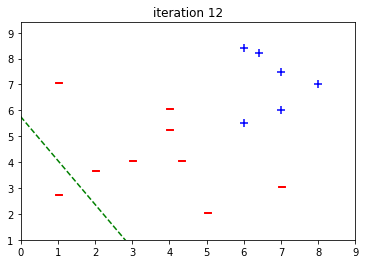

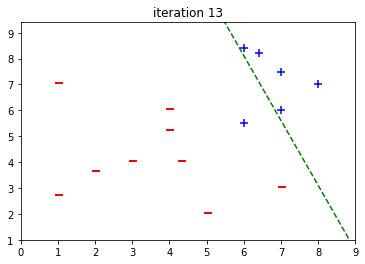

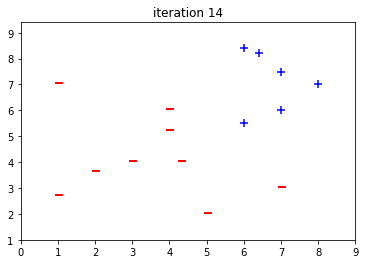

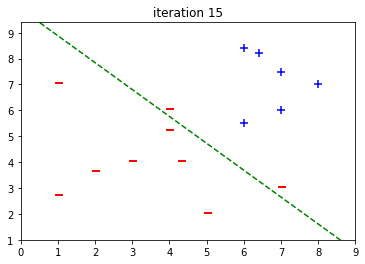

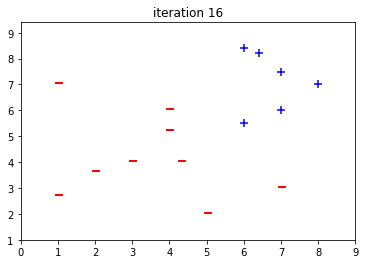

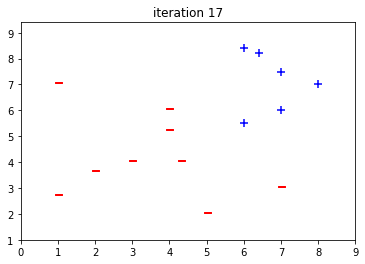

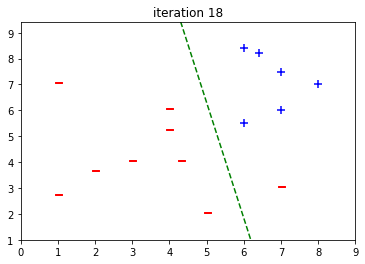

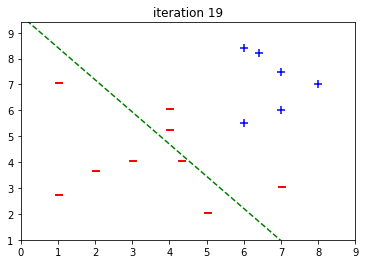

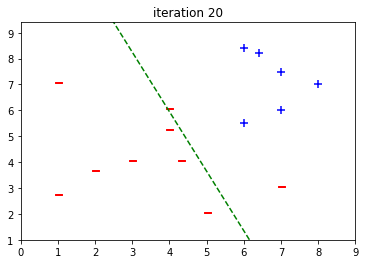

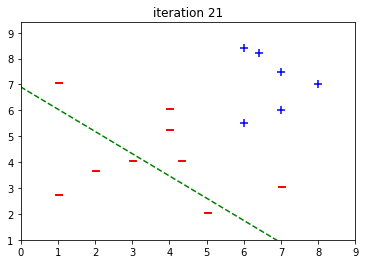

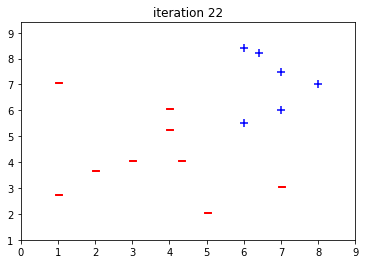

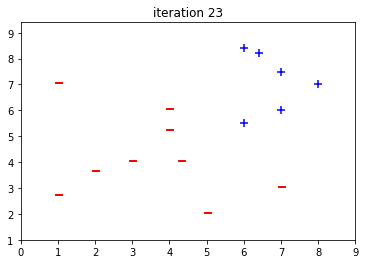

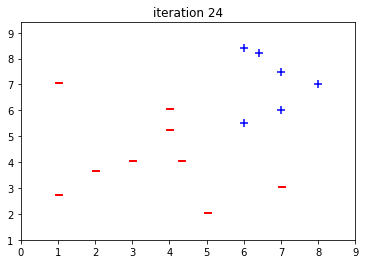

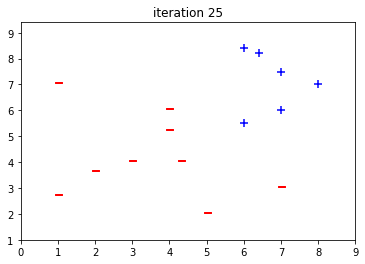

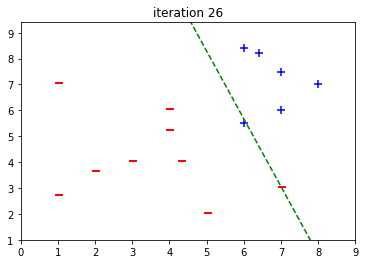

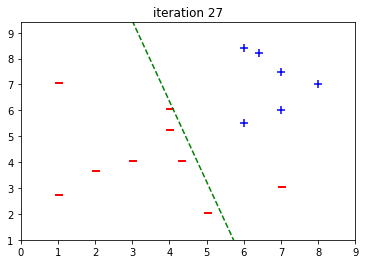

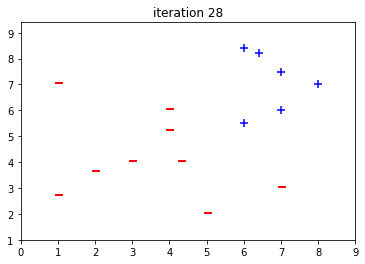

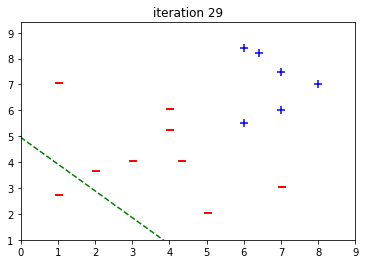

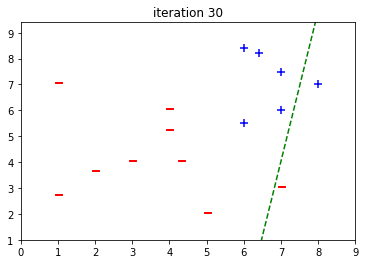

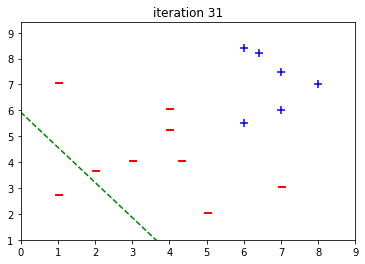

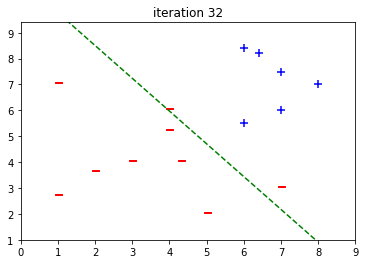

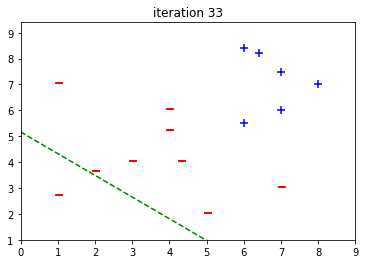

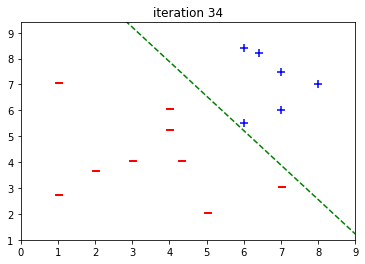

In [19]:
# run PLA
weights, success, iters = PLA(X, y, initialWeights, learningRate=0.05,
                              verbose=True, skip=1)

final weights [-2.02551368  0.08973617  0.27370446]
numer of iterations 25


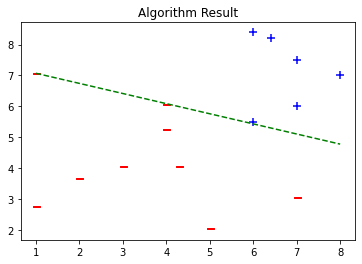

In [ ]:
# plot and print the results
fig, ax = plt.subplots(1)
plot_costs(ax, X[:, 1], X[:, 2], y)
print('final weights', weights)
plot_weight_line(ax, weights,
                 np.min(X[:, 1]), np.max(X[:, 1]))
plt.title('Algorithm Result')
print('numer of iterations', iters)


---

# 2. Hoeffding Inequality (\# of data, $N$)

## w/ Non-Linearably Separable Simulated Data


It should be reasonably clear to see why PLA cannot separate data which is very intermingled. It draws a straight line, and there is no way to draw a straight line through intermingled data to separate it into two groups. But how does it perform if the data is mostly separated with only modest overlap? Let's look at that.

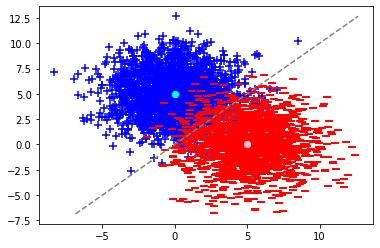

In [ ]:
np.random.seed(0)

def make_symmetricData(N):
  noise = 5
  d1 = np.random.multivariate_normal((0, 5), ((noise, 0), (0, noise)), N)    
  d2 = np.random.multivariate_normal((5, 0), ((noise, 0), (0, noise)), N)
    
  data = np.vstack((d1, d2))
  y = np.array([1]*N + [-1]*N)
  return data, y
  
X, y = make_symmetricData(N=2000) 
trueWeight = np.array([0, -1, 1])

fig, ax = plt.subplots(1)
plot_costs(ax, X[:, 0], X[:, 1], y)

plt.scatter(0, 5, c='aqua', marker='o', s=40)
plt.scatter(5, 0, c='pink', marker='o', s=40)
plot_weight_line(ax, trueWeight, np.min(X[:, 1]), np.max(X[:, 1]), color='grey')

There is no way to linearly separate this data. Let's test that by running the algorithm and inspecting the `success` flag.

In [ ]:
N = 10
sampleIdx = np.random.choice(X.shape[0], N, replace=False)

sample_X = X[sampleIdx, :]
sample_y = y[sampleIdx]

sample_X = add_one_column(sample_X)
weights, success, iters = PLA(sample_X, sample_y, max_iters=5000)
print('success =', success)

success = True


As you can see the algorithm could not linearly separate the data. But what do the results look like:

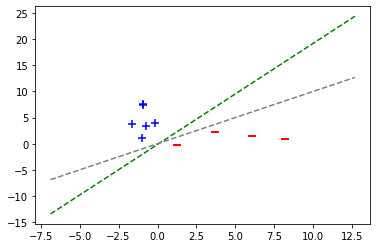

In [ ]:
fig, ax = plt.subplots(1)
plot_costs(ax, sample_X[:, 1], sample_X[:, 2], sample_y)
plot_weight_line(ax, weights, np.min(X[:, 1]), np.max(X[:, 1]))
plot_weight_line(ax, trueWeight, np.min(X[:, 1]), np.max(X[:, 1]), color='grey')

In [ ]:
from sklearn.metrics import accuracy_score

pred_sample_y = perceptron(weights, sample_X)
inSampleError = 1 - accuracy_score(sample_y, pred_sample_y)
print('in sample error: %.4f'%inSampleError)

pred_y = perceptron(weights, add_one_column(X))
outOfSampleError = 1 - accuracy_score(y, pred_y)

print('out of sample error: %.4f'%outOfSampleError)

in sample error: 0.0000
out of sample error: 0.0773


Even though the perceptron can not seperate all the data, the solution is pretty good and there are a gap between two lines. What might happen if we aquire more data?



success = False


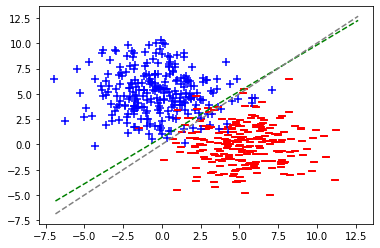

In [ ]:
N = 500
sampleIdx = np.random.choice(X.shape[0], N, replace=False)

sample_X = X[sampleIdx, :]
sample_y = y[sampleIdx]

sample_X = add_one_column(sample_X)
weights, success, iters = PLA(sample_X, sample_y, max_iters=5000)
print('success =', success)

fig, ax = plt.subplots(1)
plot_costs(ax, sample_X[:, 1], sample_X[:, 2], sample_y)
plot_weight_line(ax, weights, np.min(X[:, 1]), np.max(X[:, 1]))
plot_weight_line(ax, trueWeight, np.min(X[:, 1]), np.max(X[:, 1]), color='grey')

Now, we can see that the line of learned perceptron is much more similar to true line (grey). How about the errors?



In [ ]:
pred_sample_y = perceptron(weights, sample_X)
inSampleError = 1 - accuracy_score(sample_y, pred_sample_y)
print('in sample error: %.4f'%inSampleError)

pred_y = perceptron(weights, add_one_column(X))
outOfSampleError = 1 - accuracy_score(y, pred_y)

print('out of sample error: %.4f'%outOfSampleError)

in sample error: 0.0560
out of sample error: 0.0535


## w/ Real Data
Let's repeat the samething with real data, `breast_cancer`.

**Note** Assume the data represents true distribution, even though it is not. 

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [ ]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

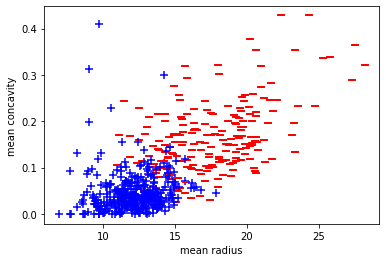

In [ ]:
X = data.data[:, [0, 6]]
y = data.target
y[y==0] = -1

fig, ax = plt.subplots(1)
plot_costs(ax, X[:, 0], X[:, 1], y)
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[6])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.show()

Let's train the PLA with 10 sampled data.

In [ ]:
N = 10
sampleIdx = np.random.choice(X.shape[0], N, replace=False)

sample_X = X[sampleIdx, :]
sample_X = add_one_column(sample_X)

sample_y = y[sampleIdx]

In [ ]:
weights, success, iters = PLA(sample_X, sample_y, max_iters=5000)
print('success =', success)

success = True


(-0.02134, 0.44814000000000004)

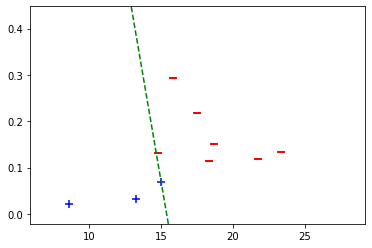

In [ ]:
fig, ax = plt.subplots(1)
plot_costs(ax, sample_X[:, 1], sample_X[:, 2], sample_y)
plot_weight_line(ax, weights,
                 np.min(sample_X[:, 1]), np.max(sample_X[:, 1]))
ax.set_xlim(xlim)
ax.set_ylim(ylim)

The `inSampleError` (training error) is 0, which is perfect. But `outSampleError` is not, which means that the gernalized performance is poor.

In [ ]:
pred_sample_y = perceptron(weights, sample_X)
inSampleError = 1 - accuracy_score(sample_y, pred_sample_y)
print('in sample error: %.4f'%inSampleError)

pred_y = perceptron(weights, add_one_column(X))
outOfSampleError = 1 - accuracy_score(y, pred_y)

print('out of sample error: %.4f'%outOfSampleError)

in sample error: 0.0000
out of sample error: 0.1037


Then let's acquire more data and train the Perceptron.

In [ ]:
N = 250
sampleIdx = np.random.choice(X.shape[0], N, replace=False)

sample_X = X[sampleIdx, :]
sample_X = add_one_column(sample_X)

sample_y = y[sampleIdx]

In [ ]:
weights, success, iters = PLA(sample_X, sample_y,
                              max_iters=50000, learningRate=0.05)
print('success =', success)

success = False


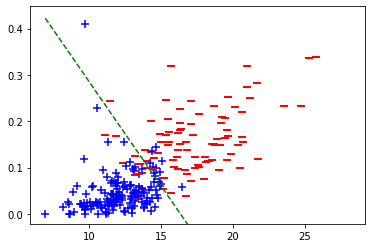

In [ ]:
fig, ax = plt.subplots(1)
plot_costs(ax, sample_X[:, 1], sample_X[:, 2], sample_y)
plot_weight_line(ax, weights, np.min(sample_X[:, 1]), np.max(sample_X[:, 1]))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

Though `inSampleError` has been increased, `outSampleError` has decreased.

In [ ]:
pred_sample_y = perceptron(weights, sample_X)
inSampleError = 1 - accuracy_score(sample_y, pred_sample_y)
print('in sample error: %.4f'%inSampleError)

pred_y = perceptron(weights, add_one_column(X))
outOfSampleError = 1 - accuracy_score(y, pred_y)

print('out of sample error: %.4f'%outOfSampleError)

in sample error: 0.1080
out of sample error: 0.0896


Now we have shown that the data can boost `generalization` performance of model which was claimed by Hoeffiding Inequality. 

How about `approximation`? It will be cover effect we learn more complex models.

Can PLA can considers user specified `error`?